# DAT405/DIT407 Introduction to Data Science and AI 
## 2022-2023, Reading Period 4
## Assignment 5: Reinforcement learning and classification



Assignment 5 by Josefin Kokkinakis and Eli Uhlin, group 30.
We have both worked around 15 hours each.

## Question 1

The first question covers a deterministic MPD, where the action is directly given by the state, described as follows:

* The agent starts in state **S** (see table below)
* The actions possible are **N** (north), **S** (south), **E** (east), and **W** west. 
* The transition probabilities in each box are deterministic (for example P(s'|s,N)=1 if s' north of s). Note, however, that you cannot move outside the grid, thus all actions are not available in every box.
* When reaching **F**, the game ends (absorbing state).
* The numbers in the boxes represent the rewards you receive when moving into that box. 
* Assume no discount in this model: $\gamma = 1$
    
    
| | | |
|----------|----------|---------|
|-1 |1|**F**|
|0|-1|1|  
|-1 |0|-1|  
|**S**|-1|1|

Let $(x,y)$ denote the position in the grid, such that $S=(0,0)$ and $F=(2,3)$.


**1a)** What is the optimal path of the MDP above? Is it unique? Submit the path as a single string of directions. E.g. NESW will make a circle.

Answer 1a:
EENN which is unique.


**1b)** What is the optimal policy (i.e. the optimal action in each state)? It is helpful if you draw the arrows/letters in the grid.

Answer 1b:
in (0,0) N or E
in (0,1) N or E
in (0,2) N or E or S
in (0,3) E
in (1,0) E
in (1,1) N or S or E or W
in (1,2) N or E
in (1,3) E
in (2,0) N or W
in (2,1) N or S
in (2,2) N


**1c)** What is expected total reward for the policy in 1a)?

Answer 1c: 0 

    since 
      (0,0) -> (1,0) means -1

      (1,0) -> (2,0) means 1, and -1+1=0 total
      
      (2,0) -> (2,1) means -1, and -1+0=-1 total
      
      (2,1) -> (2,2) means +1, and -1+1=0 total
      
      (2,2) -> F     means that the total reward is 0.

## Value Iteration

For larger problems we need to utilize algorithms to determine the optimal policy $\pi^*$. *Value iteration* is one such algorithm that iteratively computes the value for each state. Recall that for a policy to be optimal, it must satisfy the Bellman equation above, meaning that plugging in a given candidate $V^*$ in the right-hand side (RHS) of the Bellman equation should result in the same $V^*$ on the left-hand side (LHS). This property will form the basis of our algorithm. Essentially, it can be shown that repeated application of the RHS to any intial value function $V^0(s)$ will eventually lead to the value $V$ which statifies the Bellman equation. Hence repeated application of the Bellman equation will also lead to the optimal value function. We can then extract the optimal policy by simply noting what actions that satisfy the equation.    

The process of repeated application of the Bellman equation is what we here call the _value iteration_ algorithm. It practically procedes as follows:

```
epsilon is a small value, threshold
for x from i to infinity 
do
    for each state s
    do
        V_k[s] = max_a Σ_s' p(s′|s,a)*(r(a,s,s′) + γ*V_k−1[s′])
    end
    if  |V_k[s]-V_k-1[s]| < epsilon for all s
        for each state s,
        do
            π(s)=argmax_a ∑_s′ p(s′|s,a)*(r(a,s,s′) + γ*V_k−1[s′])
            return π, V_k 
        end
end

```

**Example:** We will illustrate the value iteration algorithm by going through two iterations. Below is a 3x3 grid with the rewards given in each state. Assume now that given a certain state $s$ and action $a$, there is a probability 0.8 that that action will be performed and a probability 0.2 that no action is taken. For instance, if we take action **E** in state $(x,y)$ we will go to $(x+1,y)$ 80 percent of the time (given that that action is available in that state), and remain still 20 percent of the time. We will use have a discount factor $\gamma = 0.9$. Let the initial value be $V^0(s)=0$ for all states $s\in S$. 

**Reward**:

| | | |  
|----------|----------|---------|  
|0|0|0|
|0|10|0|  
|0|0|0|  


**Iteration 1**: The first iteration is trivial, $V^1(s)$ becomes the $\max_a \sum_{s'} p(s'|s,a) r(s,a,s')$ since $V^0$ was zero for all $s'$. The updated values for each state become

| | | |  
|----------|----------|---------|  
|0|8|0|
|8|2|8|  
|0|8|0|  
  
**Iteration 2**:  
  
Staring with cell (0,0) (lower left corner): We find the expected value of each move:  
Action **S**: 0  
Action **E**: 0.8( 0 + 0.9 \* 8) + 0.2(0 + 0.9 \* 0) = 5.76  
Action **N**: 0.8( 0 + 0.9 \* 8) + 0.2(0 + 0.9 \* 0) = 5.76  
Action **W**: 0

Hence any action between **E** and **N** would be best at this stage.

Similarly for cell (1,0):

Action **N**: 0.8( 10 + 0.9 \* 2) + 0.2(0 + 0.9 \* 8) = 10.88 (Action **N** is the maximizing action)  

Similar calculations for remaining cells give us:

| | | |  
|----------|----------|---------|  
|5.76|10.88|5.76|
|10.88|8.12|10.88|  
|5.76|10.88|5.76|  



## Question 2

**2a)** Code the value iteration algorithm just described here, and show the converging optimal value function and the optimal policy for the above 3x3 grid. Make sure to consider that there may be several equally good actions for a state when presenting the optimal policy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random
from random import shuffle
from enum import Enum
from math import sqrt

from typing import List

class State:
    def __init__(self ,reward, coord, r):
        if r:
            self.val = random.randint(0,100)
        else:
            self.val = 0
        self.new_val = 0
        self.reward = reward
        self.pi : (int, int) = None
        self.difference = 0


        self.actions = []
        self.coord = coord

    def action_list_to_string(self):
        newlst = []
        for a in self.actions:
            newlst.append(str(a.coord))

        return ' '.join(newlst)


    def __str__(self):
        return "(" + str(self.get_x()) + ", " + str(self.get_y()) + ") has value: "+ str(self.val) + ") ,reward: "+ str(self.reward)+ ",actions: " + str(self.action_list_to_string()) + " and optimal policy: " + str(self.pi)

    def get_coord(self):
        return self.coord

    def get_x(self):
        return self.coord[0]

    def get_y(self):
        return self.coord[1]

    def get_val(self):
        return self.val

    def set_val(self, new_value):
        self.val = new_value

    def get_actions(self):
        return self.actions

    def add_action(self, state):
        self.actions.append(state)



def listcoord(rows, cols):
    return [(x ,y) for x in range(rows) for y in range(cols)]


def State_list(listreward, listcoord, ran):
    state_list = []
    for r, c in zip(listreward, listcoord):
        state_list.append(State(r ,c, ran))
    for s in state_list:
        for t in state_list:
            abs_x = abs(s.get_x() - t.get_x())
            abs_y = abs(s.get_y() - t.get_y())
            if ((abs_y == 1 and abs_x == 0) ^ (abs_y == 0 and abs_x == 1)):
                s.add_action(t)
    return state_list

def Value_Iteration_Algorithm(epsi, gam, delt,show):
    epsilon = epsi
    gamma = gam
    delta = delt
    g_list = []
    coord = listcoord(3,3)
    rewards = [0 for x in range(9)]
    rewards[4] = 10
    statelist = State_list(rewards, coord, not show)

    generation = 0
    for j in range(1000000):
        max_dif = 0
        for i, s in enumerate(statelist):
            max_val = 0
            for a in s.get_actions():
                new_val = (1 - delta) * (a.reward + gamma * a.val) + delta * (s.reward + gamma * s.val)

                max_val = max(max_val, new_val)
                if new_val > s.val:
                    s.pi = a.coord
            max_dif = max(max_dif, abs(max_val - s.val))
            s.new_val = max_val
        if max_dif < epsilon:
            break
        generation += 1
        if show:
            print("Generation: ", generation)
            print_matrix(statelist)
        gen_list =[]
        for s in statelist:
            gen_list.append(s.val)
            s.val = s.new_val
    
        g_list.append(gen_list)
    if show:
        print("final generation")
        print("best policies pi: ")
        for i in statelist:
            print(i)
    return g_list


def print_matrix(state: List[State]):
    dimension = int(sqrt(len(state)))
    mat = [[0 for i in range(dimension)] for i in range(dimension)]
    for s in state:
        mat[s.get_x()][s.get_y()] = s.val
    for row in mat:
        print(row)


In [3]:
yprime = Value_Iteration_Algorithm(0.01, 0.9,0.2, True)

Generation:  1
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
Generation:  2
[0, 8.0, 0]
[8.0, 2.0, 8.0]
[0, 8.0, 0]
Generation:  3
[5.760000000000001, 10.88, 5.760000000000001]
[10.88, 8.120000000000001, 10.88]
[5.760000000000001, 10.88, 5.760000000000001]
Generation:  4
[8.870400000000002, 15.804800000000002, 8.870400000000002]
[15.804800000000002, 11.295200000000001, 15.804800000000002]
[8.870400000000002, 15.804800000000002, 8.870400000000002]
Generation:  5
[12.976128000000003, 18.977408000000004, 12.976128000000003]
[18.977408000000004, 15.412592000000004, 18.977408000000004]
[12.976128000000003, 18.977408000000004, 12.976128000000003]
Generation:  6
[15.999436800000003, 22.512999680000004, 15.999436800000003]
[22.512999680000004, 18.438000320000004, 22.512999680000004]
[15.999436800000003, 22.512999680000004, 15.999436800000003]
Generation:  7
[19.089258393600005, 25.327700172800004, 19.089258393600005]
[25.327700172800004, 21.528199827200005, 25.327700172800004]
[19.089258393600005, 25.32770017

**2b)** Explain why the result of 2a) does not depend on the initial value $V_0$.

Answer 2b: 

with the 3x3 matrix that we worked with above, we can divide the different states into three sets with different characteristics, S1 = {(0,0),(0,2),(2,0),(2,2)}, S2 = {(0,1),(2,1),(1,0),(1,2), S3 = {(1,1)}
they have the following characteristics:
states in S3 have a reward attched to them, 
every state in S2 is adjacent to a state in S3 and vice versa
every state in S1 is adjacent to a state in S2 and vice versa.

let's use state(0,1) , if we set gamma to less than 1 then (0,1) will always converge to value that is approximately 51.94. values will have proportionaly less impact then direct rewards do the more generations pass, we can see this as the true value propagating out from the states with actual rewards. states in S2 will converge to the highest value than average since they are adjacent to S3 that have a direct reward 10, nodes from S3 are not adjacent to any node with rewards, but there is a 20 percent chance that it stay put and claim part of its own reward, it is also adjacent to a high value state in S2 which are a set of high value nodes, S1 is adjacent to the highest value node S2, but they have no chance of getting direct rewards, so this makes them converge to the lowest value.

below is an example of the value for (0,0) each generation, the algorithm is run 15 times with randomized starting values.


Text(0.5, 0, 'generation')

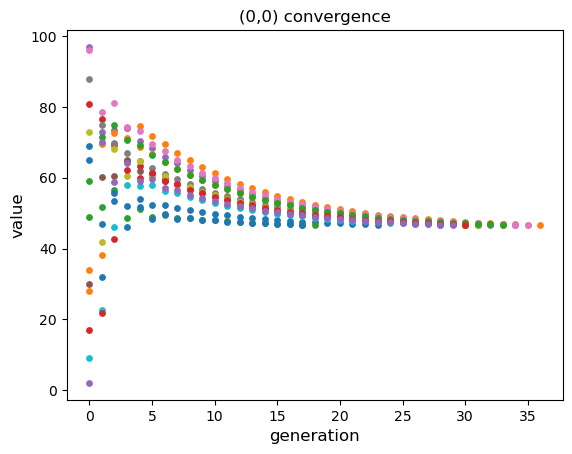

In [4]:
for i in range(15):
    yprime = Value_Iteration_Algorithm(0.1, 0.9,0.2, False)
    y = []
    for i in yprime:
        y.append(i[0])
    x = [i for i in range(len(y))]
    plt.scatter(x,y, s = 15)
plt.title('(0,0) convergence')
plt.ylabel('value', fontsize=12)
plt.xlabel('generation', fontsize=12)

**2c)** Describe your interpretation of the discount factor $\gamma$. What would happen in the two extreme cases $\gamma = 0$ and $\gamma = 1$? Given some MDP, what would be important things to consider when deciding on which value of $\gamma$ to use?

Answer 2c:


Convergence takes longer the closer gamma is to 1, and it takes shorter time the closer it is to 0
In the case of gamma = 0, the values converge after one generation, since it's only dependent on the rewards.
In the case of gamma = 1, the values never converge, since values and rewards are equally valued.

when consider what gamma value to use, you should consider how accurate you need your approximation to be and how long it will take to reach a value. If you choose a low value for gamma, your approximation of an optimal value will be more accurate, but it will take longer to calculate. a higher value will make the calculations faster but the result will be less accurate.

## Question 4

**4a)** What is the importance of exploration in reinforcement learning? Explain with an example.

Answer 4a:
Example: Imagine a person that is going to invest their money in a fund. If they find exploring to be very important and they don't aim for short term rewards, they aim for long term rewards. They will not just go for the first aalternative which at first glance may seem good but investigating more options gives the investor a greater understanding of how good the investment in the first fund is, in comparison to other funds.

**4b)** Explain what makes reinforcement learning different from supervised learning tasks such as regression or classification. 


Answer 4b:
Reinforcement learning is different from supervised learning since it does not require labeled data. It learns the data by exploring the environment. 

## Question 5

**5a)** Give a summary of how a decision tree works and how it extends to random forests.

Answer 5a:
When using decision trees, we classify data by splitting it up depending on how it "responds" to a certain question. For example, lets say we want to predict how likely it is for us to "go for a run" on a monday morning. Factors that may inpact my decision about going for a run could be, answers to the questions: is it raining?, did I sleep well?, etc. The tree contains questions like these and splits the input space into smaller regions giving us a more complex and deeper tree that better fits our data.
A disadvantage with using decision trees is that they are prone to overfitting since they are not "flexible" when it comes to classifying new samples. So when trees grow deeper, relationships between certain features may not be clear. This is why random forests was created. Random forests combines the predicitions of several decision trees, where every decision tree is trained independently of one another using different subsets of the training data and some random features. The random forests then predicts by using Bootstrap aggregation aka the "bagging method", so the different predictions produced by the decision trees depend on what training data was fed to algorithm. Thus, by using majority voting on the different predictions it choses a final prediction. So if some decision tree makes an incorrect prediction of something it does not affect the final outcome since the final prediction is based on the majority vote of the decision trees. 

**5b)** State at least one advantage and one drawback with using random forests over decision trees.

Answer 5b: An advantage with using random forests over decision trees is that they reduce overfitting. By combining the predictions of several decision trees they also have the flexability that tends to result in higher accuracy. 
A drawback with using random forests over decision trees is that random forests are more expensive since they contain several decision trees. 
It is also more difficult to interpret than decision trees. Decision trees can be interpreted easily just by following the path in the tree that leads to the leaf.